## Install the necessary libraries:

In [13]:
!pip install yfinance pandas matplotlib numpy jupyter

In [14]:
# Import required libraries
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import numpy as np

## Fetching historical stock data:

Below, I used the yfinance library to fetch data for 5 stocks from the Nifty 50 index: Reliance Industries, Tata Consultancy Services, HDFC Bank, Infosys, and ICICI Bank.
The *fetch_stock_data* function retrieves data for a given stock ticker and date range.

## Performing analyses:
1. Calculating daily percentage change:
- The *calculate_daily_change* function computes the daily percentage change using the *pct_change()* method and multiplies by 100 for a percentage representation.

2. Plotting closing prices and daily percentage changes

3. Calculating and plotting the moving average:
- The *calculate_moving_average* function computes the 20-day moving average using the *rolling()* method.
It's plotted moving average alongside the closing price in the first graph for each stock.

In [15]:
# Function to fetch stock data
def fetch_stock_data(ticker, start_date, end_date):
    stock = yf.Ticker(ticker)
    data = stock.history(start=start_date, end=end_date)
    return data

# Function to calculate daily percentage change
def calculate_daily_change(data):
    return data['Close'].pct_change() * 100

# Function to calculate moving average
def calculate_moving_average(data, window):
    return data['Close'].rolling(window=window).mean()

# Function to calculate maximum drawdown
def calculate_max_drawdown(data):
    peak = data['Close'].cummax()
    drawdown = (data['Close'] - peak) / peak
    max_drawdown = drawdown.min()
    return max_drawdown

# Function to implement moving average crossover strategy with stop-loss
def moving_average_crossover_strategy(data, short_window, long_window, stop_loss=None):
    signals = pd.DataFrame(index=data.index)
    signals['Signal'] = 0.0
    
    # Create short simple moving average
    signals['Short_MA'] = data['Close'].rolling(window=short_window, min_periods=1, center=False).mean()
    
    # Create long simple moving average
    signals['Long_MA'] = data['Close'].rolling(window=long_window, min_periods=1, center=False).mean()
    
    # Create signals
    signals['Signal'][short_window:] = np.where(signals['Short_MA'][short_window:] > signals['Long_MA'][short_window:], 1.0, 0.0)   
    
    # Generate trading orders
    signals['Position'] = signals['Signal'].diff()
    
    # Implement stop-loss
    if stop_loss is not None:
        entry_price = None
        for i in range(1, len(signals)):
            if signals['Position'].iloc[i] == 1:  # Buy signal
                entry_price = data['Close'].iloc[i]
            elif signals['Position'].iloc[i] == -1:  # Sell signal
                entry_price = None
            elif signals['Signal'].iloc[i] == 1 and entry_price is not None:  # Check for stop-loss
                current_price = data['Close'].iloc[i]
                if (current_price - entry_price) / entry_price <= -stop_loss:
                    signals['Signal'].iloc[i] = 0
                    signals['Position'].iloc[i] = -1
                    entry_price = None
    
    return signals

# Function to calculate strategy returns
def calculate_strategy_returns(data, signals):
    # Calculate daily returns
    data['Daily_Return'] = data['Close'].pct_change()
    
    # Calculate strategy returns
    signals['Strategy_Return'] = data['Daily_Return'] * signals['Signal'].shift(1)
    
    # Calculate cumulative returns
    signals['Cumulative_Strategy_Return'] = (1 + signals['Strategy_Return']).cumprod()
    signals['Cumulative_Buy_Hold_Return'] = (1 + data['Daily_Return']).cumprod()
    
    return signals

In [16]:
# Set up date ranges and stock list
end_date = datetime.now()
start_date_6m = end_date - timedelta(days=180)
start_date_2y = end_date - timedelta(days=365*2)
stocks = ['RELIANCE.NS', 'TCS.NS', 'HDFCBANK.NS', 'INFY.NS', 'ICICIBANK.NS']

# Task 1: Stock Data Analysis
- Fetches data for all 5 stocks
- Calculates daily percentage changes and 20-day moving averages
- Plots closing prices, moving averages, and daily percentage changes for each stock
- Prints basic statistics for each stock

## I have created two plots for each stock below:
- A plot showing the closing price and the 20-day moving average.
- A plot showing the daily percentage change.

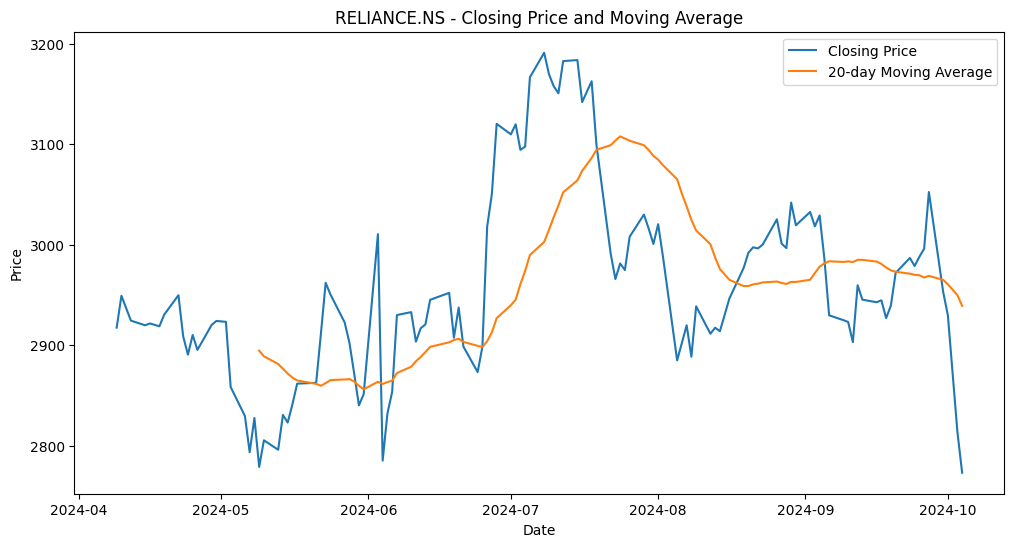

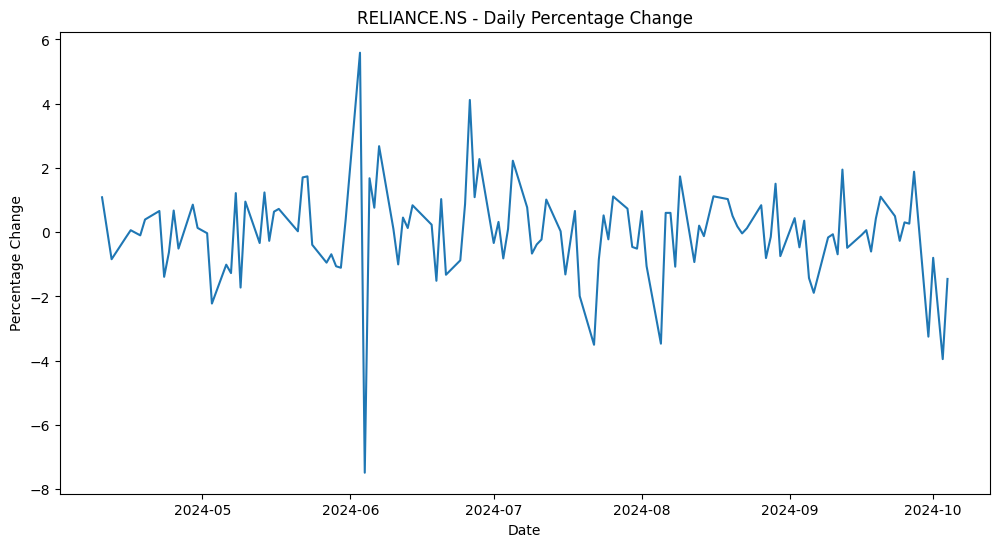


Statistics for RELIANCE.NS:
Average Daily Change: -0.03%
Max Daily Change: 5.59%
Min Daily Change: -7.49%
Current Price: 2773.05
Current 20-day MA: 2939.11


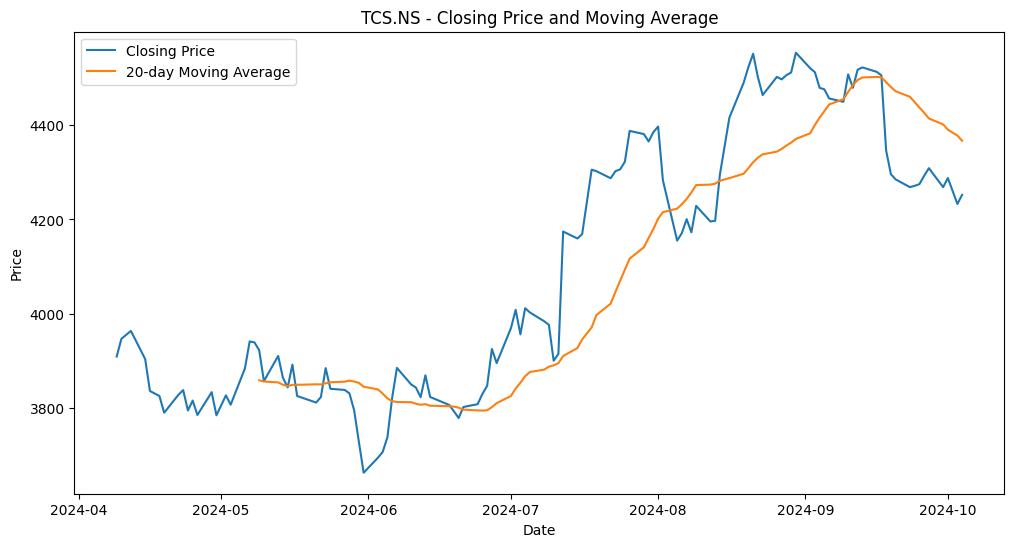

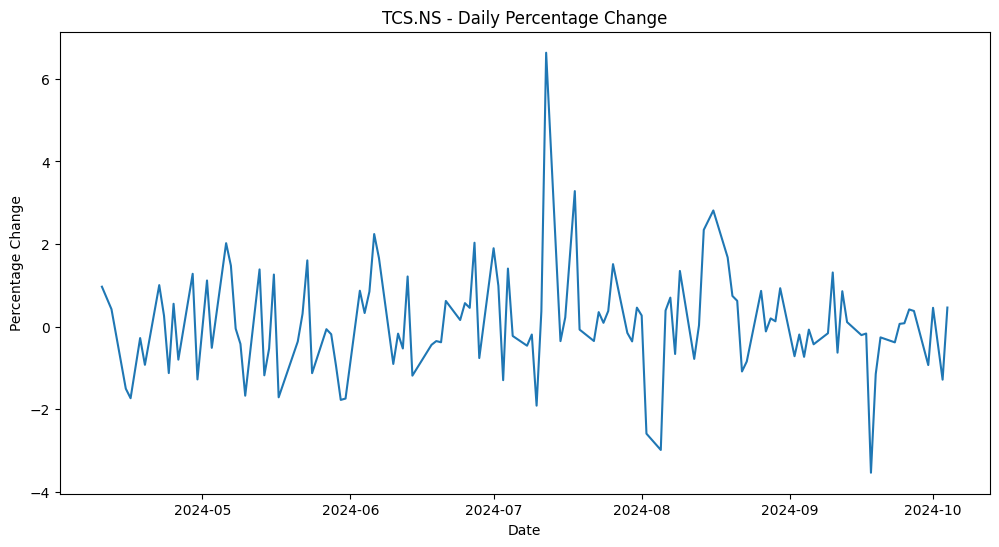


Statistics for TCS.NS:
Average Daily Change: 0.08%
Max Daily Change: 6.63%
Min Daily Change: -3.54%
Current Price: 4252.25
Current 20-day MA: 4366.85


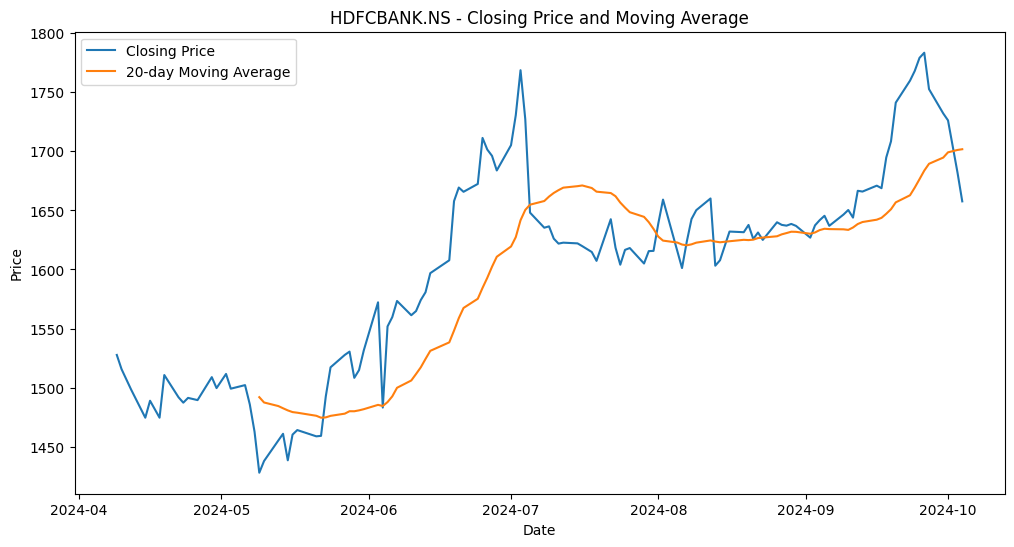

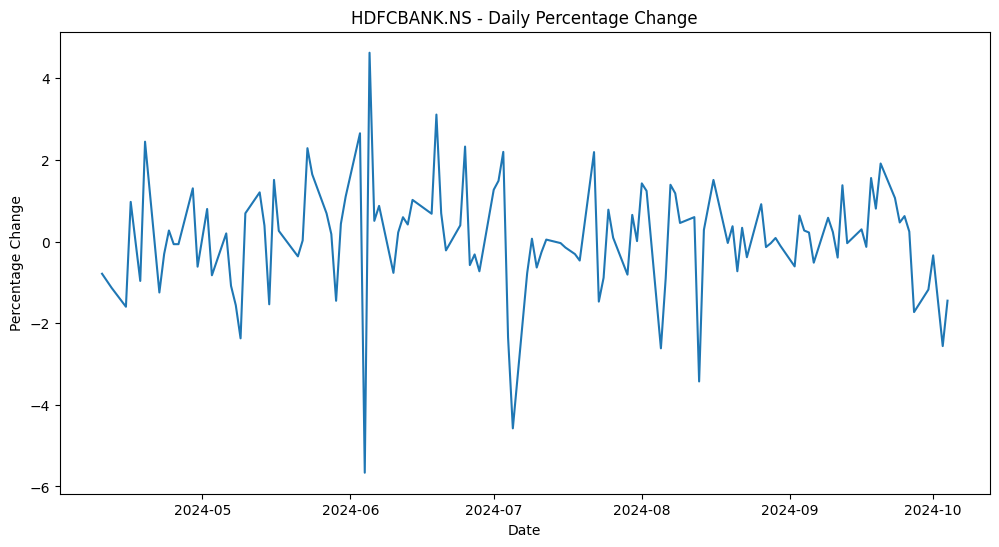


Statistics for HDFCBANK.NS:
Average Daily Change: 0.08%
Max Daily Change: 4.63%
Min Daily Change: -5.66%
Current Price: 1657.65
Current 20-day MA: 1701.77


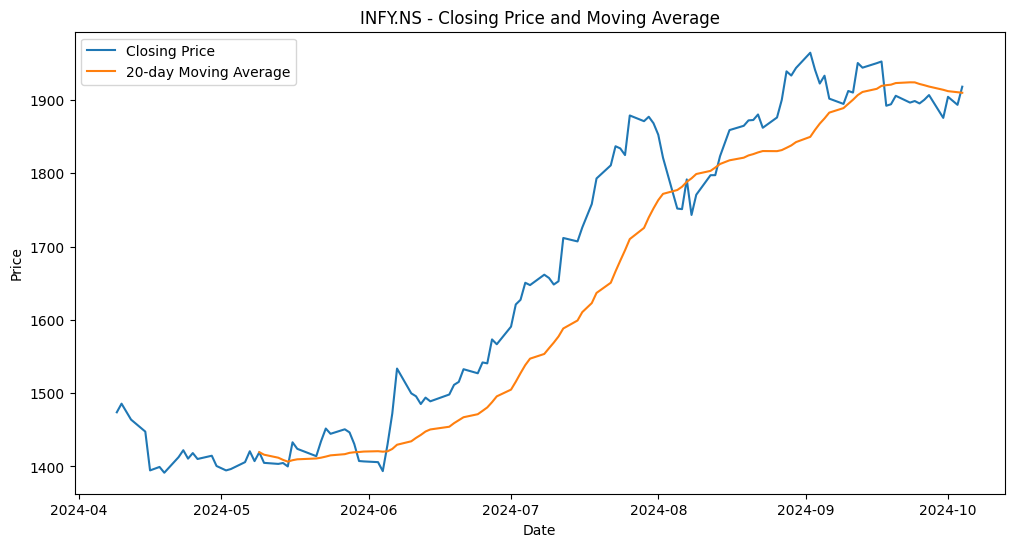

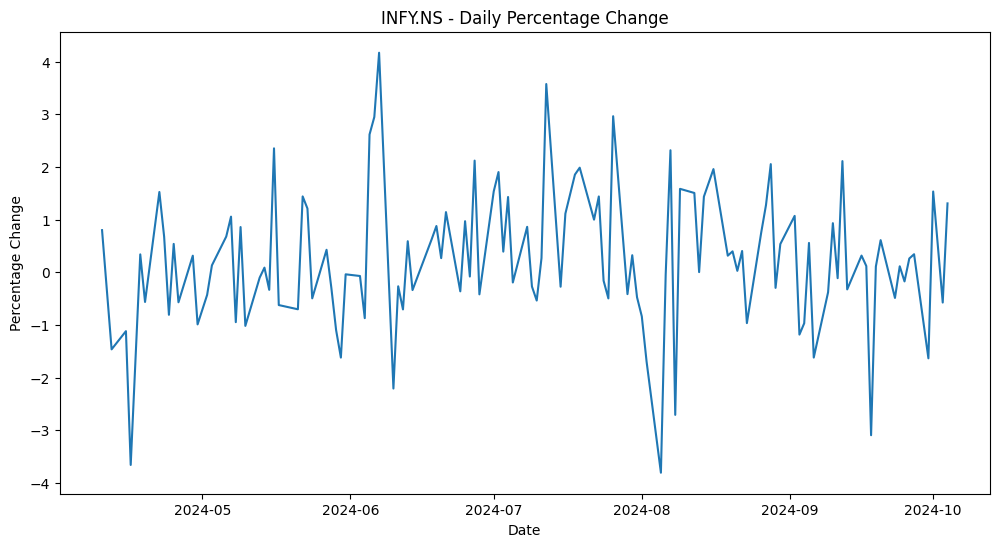


Statistics for INFY.NS:
Average Daily Change: 0.23%
Max Daily Change: 4.17%
Min Daily Change: -3.81%
Current Price: 1918.15
Current 20-day MA: 1909.86


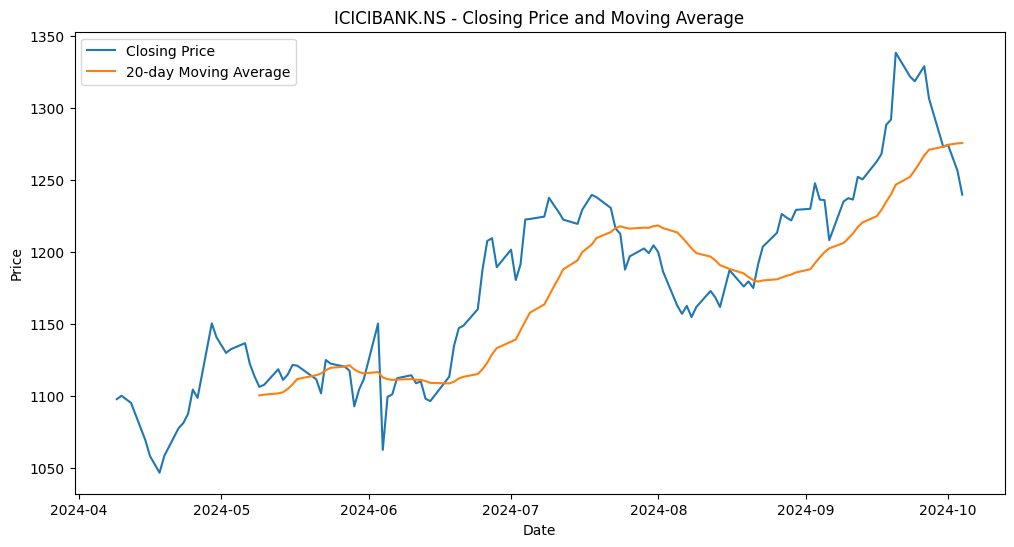

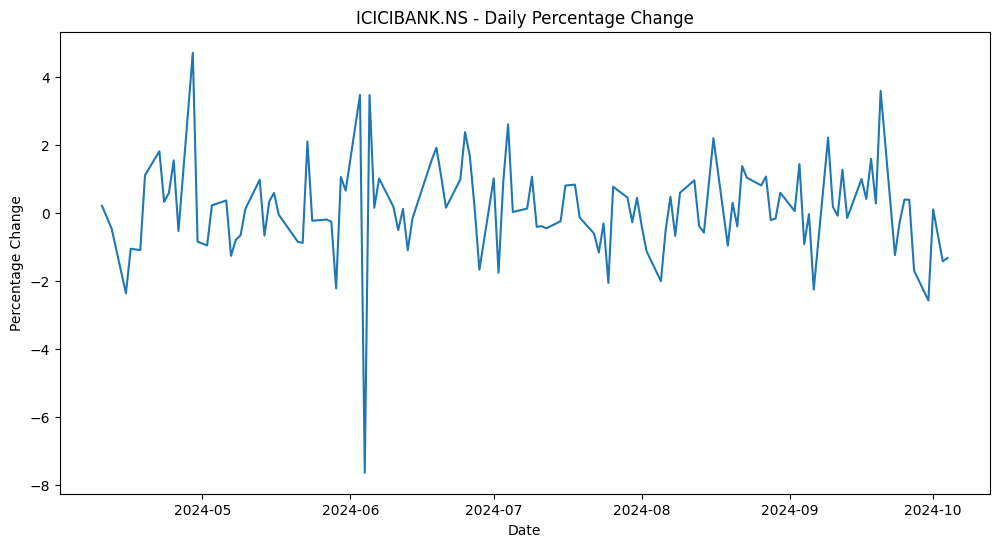


Statistics for ICICIBANK.NS:
Average Daily Change: 0.11%
Max Daily Change: 4.72%
Min Daily Change: -7.63%
Current Price: 1239.75
Current 20-day MA: 1275.63


In [17]:
# Task 1: Stock Data Analysis

for stock in stocks:
    # Fetch stock data
    data = fetch_stock_data(stock, start_date_6m, end_date)
    
    # Calculate daily percentage change
    data['Daily_Change'] = calculate_daily_change(data)
    
    # Calculate 20-day moving average
    data['MA_20'] = calculate_moving_average(data, 20)
    
    # Plot closing prices
    plt.figure(figsize=(12, 6))
    plt.plot(data.index, data['Close'], label='Closing Price')
    plt.plot(data.index, data['MA_20'], label='20-day Moving Average')
    plt.title(f'{stock} - Closing Price and Moving Average')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()
    
    # Plot daily percentage changes
    plt.figure(figsize=(12, 6))
    plt.plot(data.index, data['Daily_Change'])
    plt.title(f'{stock} - Daily Percentage Change')
    plt.xlabel('Date')
    plt.ylabel('Percentage Change')
    plt.show()
    
    # Print some statistics
    print(f"\nStatistics for {stock}:")
    print(f"Average Daily Change: {data['Daily_Change'].mean():.2f}%")
    print(f"Max Daily Change: {data['Daily_Change'].max():.2f}%")
    print(f"Min Daily Change: {data['Daily_Change'].min():.2f}%")
    print(f"Current Price: {data['Close'].iloc[-1]:.2f}")
    print(f"Current 20-day MA: {data['MA_20'].iloc[-1]:.2f}")

# Task 2: Strategy Development
- Implements a moving average crossover strategy for Reliance Industries stock
- Plots the strategy, showing buy and sell signals
- Compares the strategy returns to buy-and-hold returns
- Prints performance metrics

## 1. Developing a simple moving average crossover strategy:
I've implemented the *moving_average_crossover_strategy* function, which calculates a short-term (50-day) and long-term (200-day) moving average.
The strategy generates a buy signal when the short-term MA crosses above the long-term MA, and a sell signal when it crosses below.

## 2. Backtesting the strategy:
- The *calculate_strategy_returns* function calculates the returns generated by the strategy.
- Then it compares these returns to a simple buy-and-hold approach.

## 3. Calculating and comparing returns:
- First, I plotted the closing price along with both moving averages, marking buy and sell signals.
- Next, I also plotted the cumulative returns of the strategy versus the buy-and-hold approach.
- Finally, I printed out the total returns for both the strategy and buy-and-hold, as well as the strategy's outperformance.

C:\Users\aarya\AppData\Local\Temp\ipykernel_15160\2040780778.py:34: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  signals['Signal'][short_window:] = np.where(signals['Short_MA'][short_window:] > signals['Long_MA'][short_window:], 1.0, 0.0)


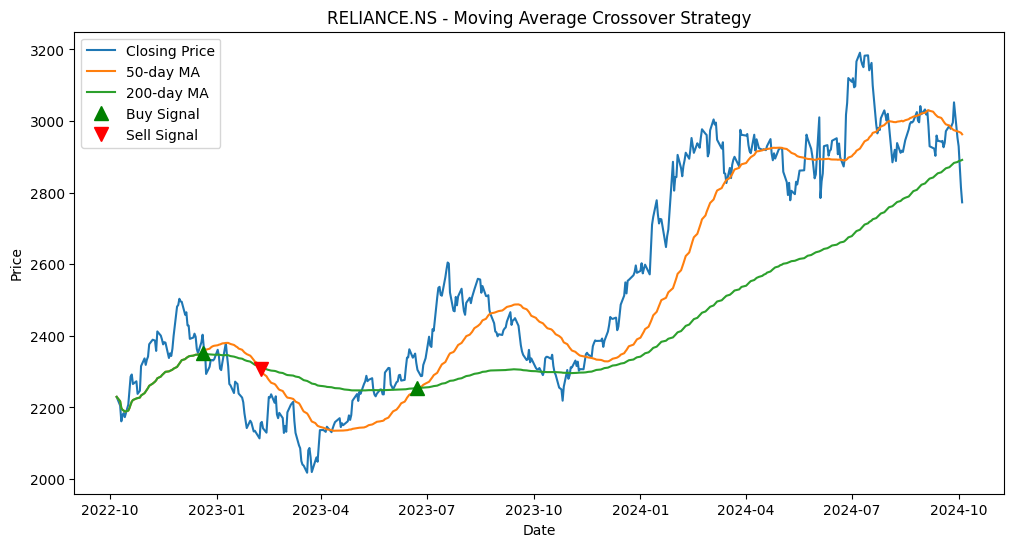

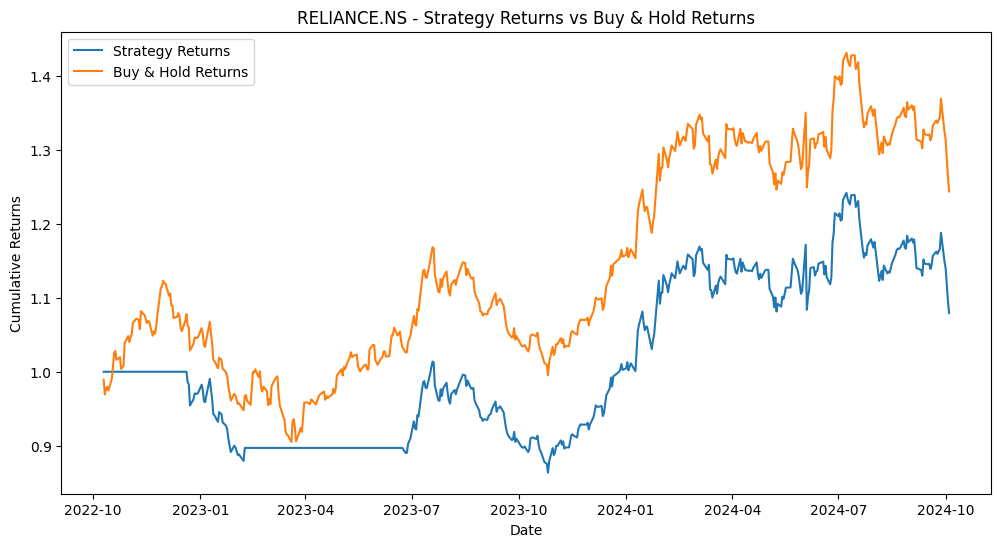


Performance Metrics for RELIANCE.NS:
Strategy Total Return: 7.92%
Buy & Hold Total Return: 24.37%
Strategy Outperformance: -16.46%


In [18]:
# Task 2: Strategy Development

# Select one stock for strategy implementation (using Reliance Industries)
selected_stock = 'RELIANCE.NS'

# Fetch 2 years of data for the selected stock
data = fetch_stock_data(selected_stock, start_date_2y, end_date)

# Implement moving average crossover strategy
short_window = 50
long_window = 200
signals = moving_average_crossover_strategy(data, short_window, long_window)

# Calculate returns
returns = calculate_strategy_returns(data, signals)

# Plot the strategy
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Close'], label='Closing Price')
plt.plot(signals.index, signals['Short_MA'], label=f'{short_window}-day MA')
plt.plot(signals.index, signals['Long_MA'], label=f'{long_window}-day MA')
plt.plot(signals[signals['Position'] == 1].index, 
         signals['Short_MA'][signals['Position'] == 1],
         '^', markersize=10, color='g', label='Buy Signal')
plt.plot(signals[signals['Position'] == -1].index, 
         signals['Short_MA'][signals['Position'] == -1],
         'v', markersize=10, color='r', label='Sell Signal')
plt.title(f'{selected_stock} - Moving Average Crossover Strategy')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Plot strategy returns vs buy-and-hold returns
plt.figure(figsize=(12, 6))
plt.plot(returns.index, returns['Cumulative_Strategy_Return'], label='Strategy Returns')
plt.plot(returns.index, returns['Cumulative_Buy_Hold_Return'], label='Buy & Hold Returns')
plt.title(f'{selected_stock} - Strategy Returns vs Buy & Hold Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.show()

# Print performance metrics
strategy_return = returns['Cumulative_Strategy_Return'].iloc[-1] - 1
buy_hold_return = returns['Cumulative_Buy_Hold_Return'].iloc[-1] - 1
print(f"\nPerformance Metrics for {selected_stock}:")
print(f"Strategy Total Return: {strategy_return:.2%}")
print(f"Buy & Hold Total Return: {buy_hold_return:.2%}")
print(f"Strategy Outperformance: {strategy_return - buy_hold_return:.2%}")

# Task 3: Risk Management
- Calculates and prints the maximum drawdown for each stock over the 6-month period
- Implements the moving average crossover strategy with a 5% stop-loss
- Compares the performance of the strategy with and without stop-loss to the buy-and-hold approach
- Prints comparative performance metrics

## 1. Calculating maximum drawdown:
- I've implemented the calculate_max_drawdown function, which calculates the maximum drawdown for a given stock over the specified period. In the main function, I calculated and printed the maximum drawdown for each of the 5 stocks over the 6-month period.

## 2. Implementing a stop-loss mechanism:
- I've modified the *moving_average_crossover_strategy* function to include an optional stop-loss parameter.
- When a stop-loss is specified, the function checks if the price has dropped below the stop-loss threshold after each buy signal. If it has, it generates a sell signal.

## 3. Comparing performance:
- I ran the strategy twice for the selected stock (Reliance Industries in this case): once without a stop-loss and once with a 5% stop-loss.
- Next, I plotted the cumulative returns for both versions of the strategy alongside the buy-and-hold returns for comparison.
- Finally, I printed out performance metrics for both versions of the strategy and the buy-and-hold approach.


Maximum Drawdowns (6-month period):
RELIANCE.NS: -13.10%
TCS.NS: -7.59%
HDFCBANK.NS: -9.47%
INFY.NS: -7.22%
ICICIBANK.NS: -7.65%


C:\Users\aarya\AppData\Local\Temp\ipykernel_15160\2040780778.py:34: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  signals['Signal'][short_window:] = np.where(signals['Short_MA'][short_window:] > signals['Long_MA'][short_window:], 1.0, 0.0)
C

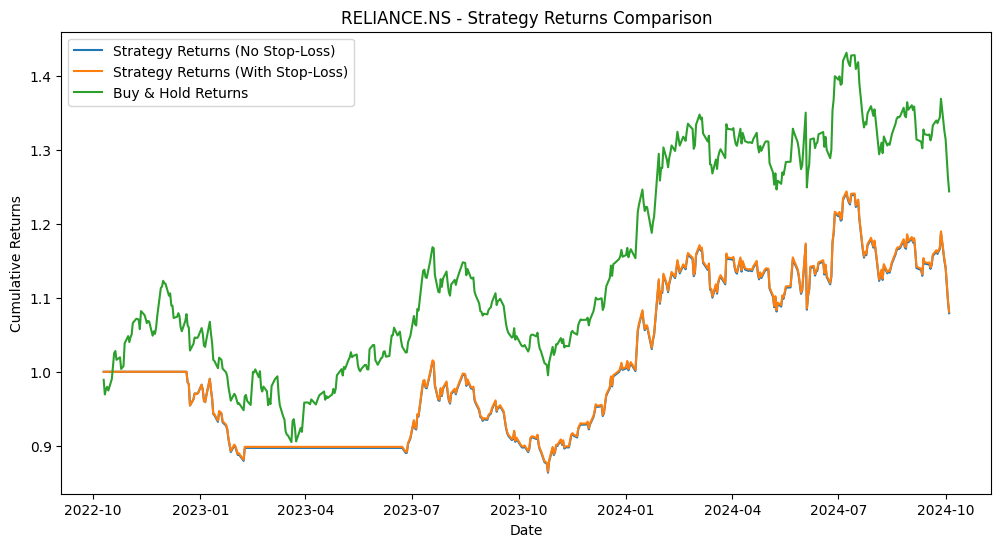


Performance Metrics for RELIANCE.NS:
Strategy Total Return (No Stop-Loss): 7.92%
Strategy Total Return (With Stop-Loss): 8.09%
Buy & Hold Total Return: 24.37%
Strategy Outperformance (No Stop-Loss): -16.46%
Strategy Outperformance (With Stop-Loss): -16.28%


In [19]:
# Task 3: Risk Management

# Calculate maximum drawdown for each stock over 6 months
print("\nMaximum Drawdowns (6-month period):")
for stock in stocks:
    data_6m = fetch_stock_data(stock, start_date_6m, end_date)
    max_drawdown = calculate_max_drawdown(data_6m)
    print(f"{stock}: {max_drawdown:.2%}")

# Implement moving average crossover strategy with stop-loss
stop_loss = 0.05  # 5% stop-loss
signals_with_stop_loss = moving_average_crossover_strategy(data, short_window, long_window, stop_loss)
returns_with_stop_loss = calculate_strategy_returns(data, signals_with_stop_loss)

# Plot strategy returns comparison
plt.figure(figsize=(12, 6))
plt.plot(returns.index, returns['Cumulative_Strategy_Return'], label='Strategy Returns (No Stop-Loss)')
plt.plot(returns_with_stop_loss.index, returns_with_stop_loss['Cumulative_Strategy_Return'], label='Strategy Returns (With Stop-Loss)')
plt.plot(returns.index, returns['Cumulative_Buy_Hold_Return'], label='Buy & Hold Returns')
plt.title(f'{selected_stock} - Strategy Returns Comparison')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.show()

# Print performance metrics comparison
print(f"\nPerformance Metrics for {selected_stock}:")

strategy_return_no_stop = returns['Cumulative_Strategy_Return'].iloc[-1] - 1
strategy_return_stop = returns_with_stop_loss['Cumulative_Strategy_Return'].iloc[-1] - 1
buy_hold_return = returns['Cumulative_Buy_Hold_Return'].iloc[-1] - 1

print(f"Strategy Total Return (No Stop-Loss): {strategy_return_no_stop:.2%}")
print(f"Strategy Total Return (With Stop-Loss): {strategy_return_stop:.2%}")
print(f"Buy & Hold Total Return: {buy_hold_return:.2%}")
print(f"Strategy Outperformance (No Stop-Loss): {strategy_return_no_stop - buy_hold_return:.2%}")
print(f"Strategy Outperformance (With Stop-Loss): {strategy_return_stop - buy_hold_return:.2%}")